# Paper reproduction of tables and figures

## package dependencies

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
from tqdm import tqdm
import networkit as nk

from model import DrBC
from utils import Metrics
from generator import TrainGraph, TestGraph
from sklearn.decomposition import PCA
from torch_geometric.nn import Node2Vec

plt.style.use('ggplot')

## reproduction
There are 2 figures and 11 tables for reproduction

### figure 3.

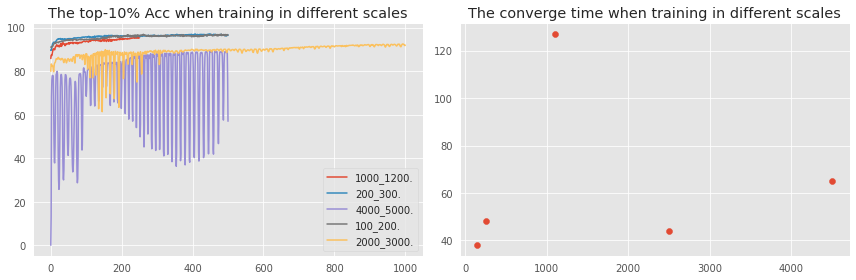

In [2]:
log_files = [ os.path.join('logs', file) for file in os.listdir('logs') ]
fig, ax = plt.subplots(1,2,figsize=(12, 4))
time_x = [1100, 250,4500, 150,   2500]
time_y = []

for log_file in log_files:
    with open(log_file, "rb") as f:
        logs = pickle.load(f)
        time_y.append(int(logs['time'][1]-logs['time'][0]))
        ax[0].set_title("The top-10% Acc when training in different scales")
        ax[0].plot(range(len(logs['eval_acc'])), [acc/100 for acc in logs['eval_acc']], label=log_file.split('/')[-1][:-3])
        ax[0].legend()
        
ax[1].set_title("The converge time when training in different scales")
ax[1].scatter(time_x, time_y)
fig.set_tight_layout(True)
fig.savefig('reproduce/figure3.png')
plt.show()

### figure 4.

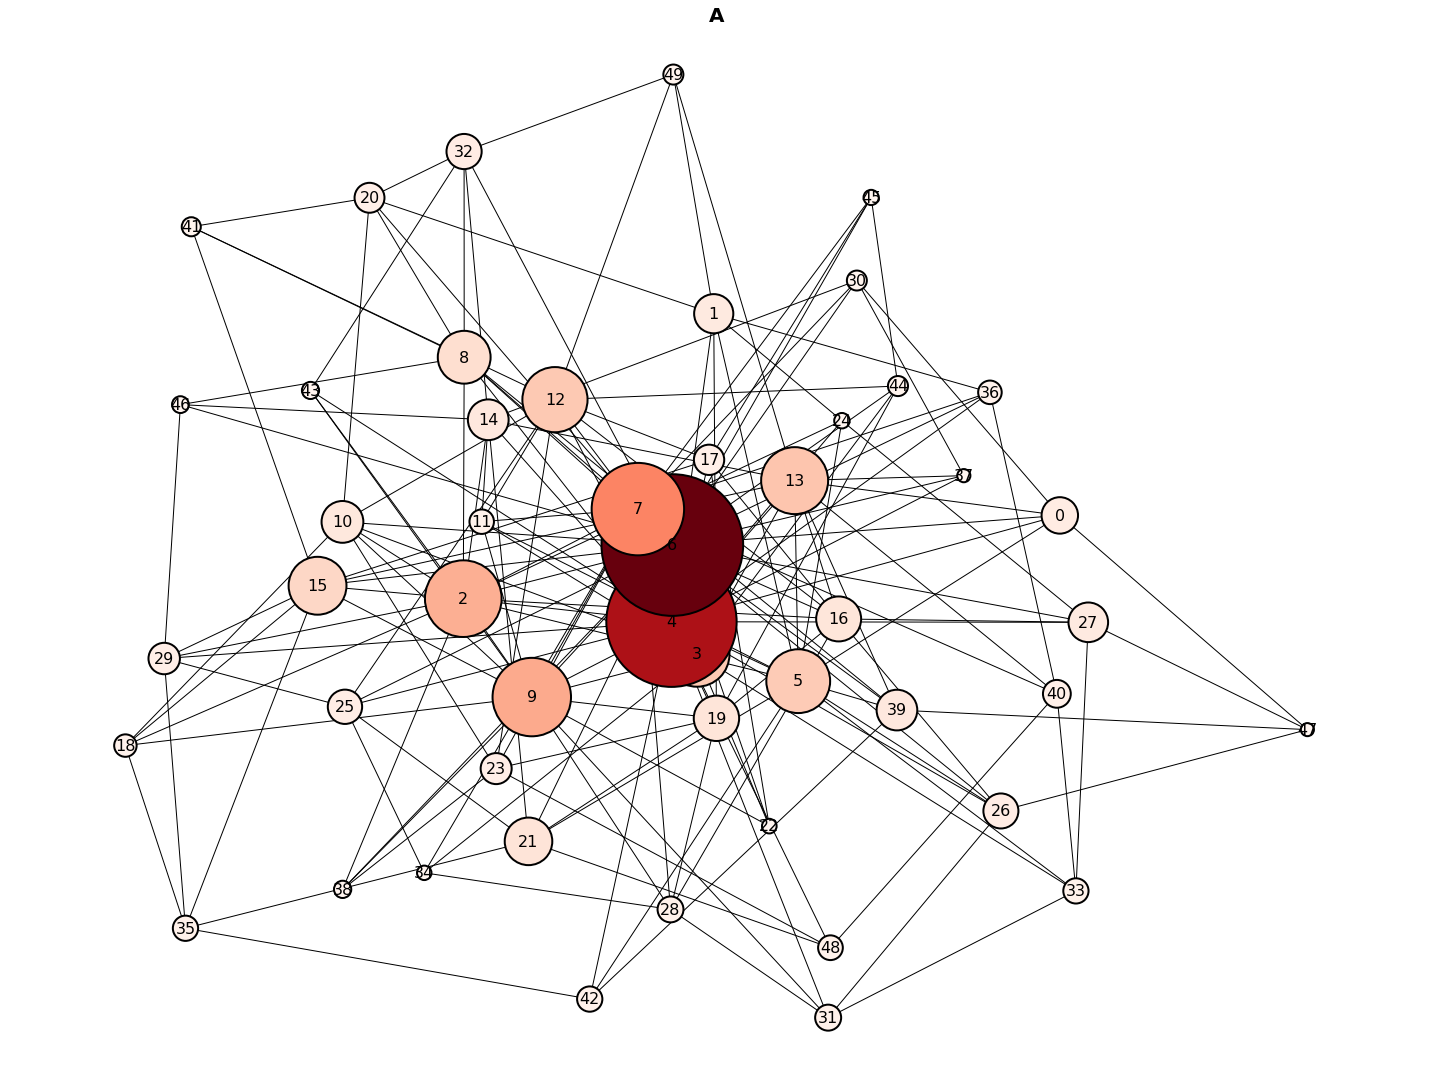

In [3]:
graph = nx.powerlaw_cluster_graph(n=50, m=4, p=0.05)
bc = list(nx.betweenness_centrality(graph).values())
max_bc, min_bc = max(bc), min(bc)
bc_cmap = [(v-min_bc)/(max_bc-min_bc) for v in bc]

fig, ax = plt.subplots(figsize=(20, 15))
nx.draw_networkx(
    graph,
    with_labels=True,
    node_size=[v*100000 for v in bc],
    node_color=bc_cmap,
    cmap=plt.cm.Reds,
    font_size=16,
    font_color="black",
    edgecolors="black",
    linewidths=2
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("A", font)
# Change font color for legend
font["color"] = "r"

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
fig.savefig('reproduce/figure4_graph.png')
plt.axis("off")
plt.show()

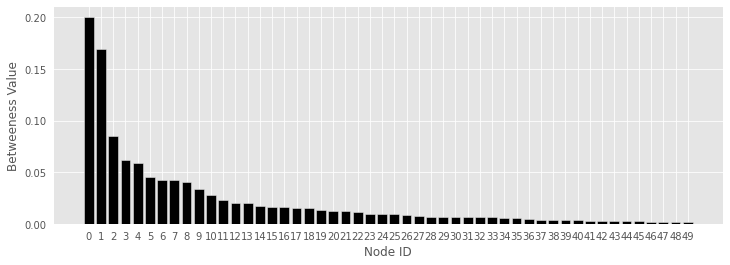

In [4]:
y_ticks = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]
x_ticks = range(len(bc))
plt.figure(figsize=(12, 4))
plt.yticks(y_ticks)
plt.xticks(x_ticks)
plt.bar(x_ticks, sorted(bc, reverse=True), color="black")
plt.ylabel("Betweeness Value")
plt.xlabel("Node ID")
plt.savefig('reproduce/figure4_bcvalue.png')
plt.show()

#### Enbedding PCA plotting

In [5]:
model = DrBC()
model.load_state_dict(torch.load('model_result/1000_1200.pth'))

<All keys matched successfully>

In [6]:
edge_idx = [[], []]
degrees = []
for begin_node, end_node in graph.edges:
    # undirected
    edge_idx[0].append(begin_node)
    edge_idx[1].append(end_node)
    edge_idx[0].append(end_node)
    edge_idx[1].append(begin_node)

degrees.extend(
    [value for _, value in nx.degree(graph)]
)
result = model.encoder(
    torch.tensor([[degree, 1, 1] for degree in degrees], dtype=torch.float),
    torch.tensor(edge_idx, dtype=torch.long)
)

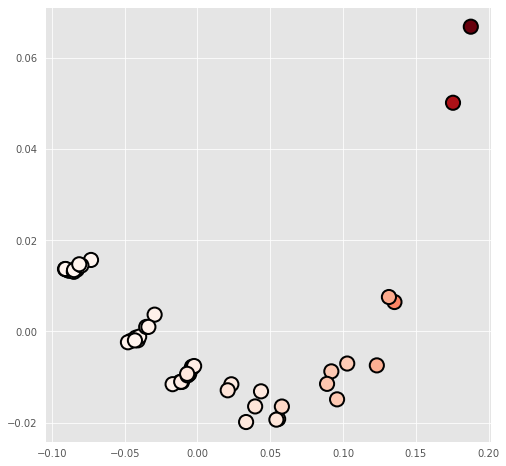

In [7]:
pca2 = PCA(n_components=2)
result_pca = pca2.fit_transform(result.detach().numpy())
plt.figure(figsize=(8,8))
plt.scatter(result_pca[:, 0], result_pca[:, 1],cmap=plt.cm.Reds, c=bc_cmap, linewidths=2, edgecolors="black", s=200)
plt.savefig('reproduce/figure4_pca_drbc.png')
plt.show()

#### Learning Node2Vec and Pca plotting its embedding

In [10]:
model = Node2Vec(
 torch.tensor(edge_idx, dtype=torch.long),embedding_dim=128, p=1, q=2, walk_length=20,
 context_size=10, walks_per_node=10   
)
device = 'cpu'
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.1)

# train 20 epochs
for epoch in range(1, 21):
    model.train()
    total_loss = 0

    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01, Loss: 9.6601


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02, Loss: 7.2551


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03, Loss: 5.8228


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04, Loss: 4.9783


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05, Loss: 4.5232


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06, Loss: 4.3815


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07, Loss: 4.2365


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08, Loss: 4.1799


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09, Loss: 4.0319


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Loss: 3.7886


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, Loss: 3.7716


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, Loss: 3.6846


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, Loss: 3.5611


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, Loss: 3.5239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, Loss: 3.4575


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16, Loss: 3.2884


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17, Loss: 3.1768


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18, Loss: 3.1548


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19, Loss: 3.0248


100%|██████████| 1/1 [00:13<00:00, 13.92s/it]

Epoch: 20, Loss: 3.0230


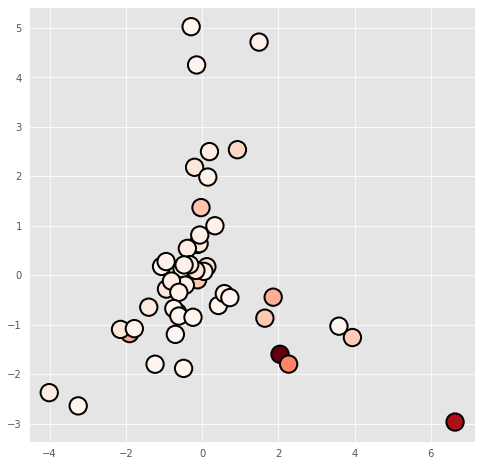

In [18]:
pca2 = PCA(n_components=2)
z = model(torch.arange(50, device=device))
result_pca = pca2.fit_transform(z.detach().numpy())
plt.figure(figsize=(8,8))
plt.scatter(result_pca[:, 0], result_pca[:, 1],cmap=plt.cm.Reds, c=bc_cmap, linewidths=2, edgecolors="black",s=300)
plt.savefig('reproduce/figure4_pca_n2v.png')
plt.show()

## Generating all testing data

In [133]:
scales = ['5000', '10000', '20000', '50000', '100000']
N = 10
for _, scale in enumerate(tqdm(scales)):
    for i in tqdm(range(N)):
        data = TrainGraph(batch_size=1, scale=(int(scale), int(scale)+1))
        data.save(f"test_30/{scale}_{i}.pkl")

  0%|          | 0/3 [15:25<?, ?it/s]


KeyboardInterrupt: 

### Table 6. and Table 7.
* run **10 times** for each scale
* find the **mean** and **std** to draw a table

In [75]:
train_scales = ["100_200", "200_300", "1000_1200", "2000_3000", "4000_5000"]
test_scales = [5000, 10000, 20000]
device = "cpu"
N = 10

result = [[ [[], [], [], [], []] for j in range(len(test_scales))] for i in range(len(train_scales))]

for i, train_scale in enumerate(train_scales):
    # load the model
    model = DrBC()
    model.load_state_dict(torch.load(os.path.join('model_result', f'{train_scale}.pth')))
    model.to(device)
    for j, test_scale in enumerate(test_scales):
        for k in range(N):
            # load data
            data = TrainGraph(batch_size=1, scale=None, path=os.path.join('test_30', f'{test_scale}_{k}.pkl'))
            metrics = Metrics()
            model.eval()
            # preparing the data
            graph_input = data.get_input()
            edge_idx = data.get_edge_idx()
            gt = data.get_ground_truth()

            # converting the data into torch tensor and certain device
            graph_input = torch.tensor(graph_input, dtype=torch.float)
            edge_idx = torch.tensor(edge_idx, dtype=torch.long)
            gt = torch.tensor(gt).view(-1, 1)

            with torch.no_grad():
                metrics.start_timer()
                pred = model(graph_input.to(device), edge_idx.to(device))
                metrics.end_timer()
                metrics.set_output(pred, gt)
            
            result[i][j][0].append(metrics.top_k(k=1))
            result[i][j][1].append(metrics.top_k(k=5))
            result[i][j][2].append(metrics.top_k(k=10))
            result[i][j][3].append(metrics.kendall_tau())
            result[i][j][4].append(metrics.get_runtime())

print("======================= TOP-1% =======================")
for i, train_scale in enumerate(train_scales):
    print(f"\t{train_scale}: ", end="")
    for j, test_scale in enumerate(test_scales):
        avg = np.mean(result[i][j][0])
        std = np.std(result[i][j][0])
        
        print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
    print()
print("======================= TOP-5% =======================")
for i, train_scale in enumerate(train_scales):
    print(f"\t{train_scale}: ", end="")
    for j, test_scale in enumerate(test_scales):
        avg = np.mean(result[i][j][1])
        std = np.std(result[i][j][1])
        
        print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
    print()
print("======================= TOP-10% =======================")
for i, train_scale in enumerate(train_scales):
    print(f"\t{train_scale}: ", end="")
    for j, test_scale in enumerate(test_scales):
        avg = np.mean(result[i][j][2])
        std = np.std(result[i][j][2])
        
        print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
    print()
print("======================= Kendall =======================")
for i, train_scale in enumerate(train_scales):
    print(f"\t{train_scale}: ", end="")
    for j, test_scale in enumerate(test_scales):
        avg = np.mean(result[i][j][3])
        std = np.std(result[i][j][3])
        print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
    print()
    
print("======================= Runtime =======================")
for i, train_scale in enumerate(train_scales):
    print(f"\t{train_scale}: ", end="")
    for j, test_scale in enumerate(test_scales):
        avg = np.mean(result[i][j][4])
        std = np.std(result[i][j][4])
        print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
    print()

======================= TOP-1% =======================
	100_200: 88.000±3.347	86.400±2.691	85.800±1.453	
	200_300: 92.600±2.010	90.100±2.508	88.950±1.457	
	1000_1200: 96.200±1.887	92.200±3.059	90.900±1.261	
	2000_3000: 94.800±2.400	91.400±2.577	90.700±1.435	
	4000_5000: 93.400±1.800	90.300±2.934	89.200±1.764	
======================= TOP-5% =======================
	100_200: 82.680±1.539	80.340±1.608	77.190±0.957	
	200_300: 86.080±1.705	84.100±1.250	81.350±1.216	
	1000_1200: 91.680±1.742	88.820±1.328	85.590±1.015	
	2000_3000: 91.000±1.354	89.200±1.110	86.850±1.005	
	4000_5000: 88.880±1.262	87.260±1.223	85.040±0.842	
======================= TOP-10% =======================
	100_200: 83.620±1.830	79.360±1.148	75.020±0.926	
	200_300: 86.060±1.156	82.450±0.745	78.805±0.933	
	1000_1200: 91.220±1.014	88.210±0.802	84.210±1.138	
	2000_3000: 91.340±1.183	89.190±0.547	85.940±0.993	
	4000_5000: 89.780±1.234	88.030±0.377	84.990±0.913	
======================= Kendall =======================
	100_200: 

In [3]:
def kadabra(graph, bc, metrics):
    graph = nk.nxadapter.nx2nk(graph)
    alg = nk.centrality.KadabraBetweenness(graph)
    metrics.start_timer()
    alg.run()
    metrics.end_timer()
    metrics.set_output(torch.tensor(alg.scores()), bc)
    return {
     "time": metrics.get_runtime(), "1Acc": metrics.top_k(k=1), "5Acc": metrics.top_k(k=5),
     "10Acc": metrics.top_k(k=10), "Kendall": metrics.kendall_tau()
    }
def RK(graph, bc, metrics):
    graph = nk.nxadapter.nx2nk(graph)
    alg = nk.centrality.ApproxBetweenness(graph)
    metrics.start_timer()
    alg.run()
    metrics.end_timer()
    metrics.set_output(torch.tensor(alg.scores()), bc)
    return {
     "time": metrics.get_runtime(), "1Acc": metrics.top_k(k=1), "5Acc": metrics.top_k(k=5),
     "10Acc": metrics.top_k(k=10), "Kendall": metrics.kendall_tau()
    } 

### RK results

In [67]:
#train_scales = ["100_200", "200_300", "1000_1200", "2000_3000", "4000_5000"]
test_scales = [5000, 10000, 20000]

N = 10

result = [ [[], [], [], [], []] for j in range(len(test_scales))]

#for i, train_scale in enumerate(train_scales):
    # load the model
    #model = DrBC()
    #model.load_state_dict(torch.load(os.path.join('model_result', f'{train_scale}.pth')))
    #model.to(device)
for j, test_scale in enumerate(test_scales):
    for k in range(N):
        metrics = Metrics()
        # load data
        data = TrainGraph(batch_size=1, scale=None, path=os.path.join('test_30', f'{test_scale}_{k}.pkl'))
        gt = data.get_ground_truth()
        r = RK(data.graphs[0], torch.tensor(gt).view(-1, 1), metrics)

        result[j][0].append(r["1Acc"])
        result[j][1].append(r["5Acc"])
        result[j][2].append(r["10Acc"])
        result[j][3].append(r["Kendall"])
        result[j][4].append(r["time"])
print("======================= TOP-1% =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j][0])
    std = np.std(result[j][0])

    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()
print("======================= TOP-5% =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j][1])
    std = np.std(result[j][1])

    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()
print("======================= TOP-10% =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j][2])
    std = np.std(result[j][2])

    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()
print("======================= Kendall =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j][3])
    std = np.std(result[j][3])
    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()
    
print("======================= Runtime =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j][4])
    std = np.std(result[j][4])
    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()

======================= TOP-1% =======================
97.800±1.077	97.100±1.136	95.450±1.274	
======================= TOP-5% =======================
95.120±1.009	93.340±0.770	90.610±0.336	
======================= TOP-10% =======================
93.860±0.727	91.700±0.492	88.440±0.440	
======================= Kendall =======================
0.803±0.004	0.754±0.005	0.695±0.002	
======================= Runtime =======================
12.600±0.490	31.800±2.482	72.600±3.200	


### kadabra result more quickly

In [66]:
#train_scales = ["100_200", "200_300", "1000_1200", "2000_3000", "4000_5000"]
test_scales = [5000, 10000, 20000]

N = 10

result = [ [[], [], [], [], []] for j in range(len(test_scales))]

#for i, train_scale in enumerate(train_scales):
    # load the model
    #model = DrBC()
    #model.load_state_dict(torch.load(os.path.join('model_result', f'{train_scale}.pth')))
    #model.to(device)
for j, test_scale in enumerate(test_scales):
    for k in range(N):
        metrics = Metrics()
        # load data
        data = TrainGraph(batch_size=1, scale=None, path=os.path.join('test_30', f'{test_scale}_{k}.pkl'))
        gt = data.get_ground_truth()
        r = kadabra(data.graphs[0], torch.tensor(gt).view(-1, 1), metrics)

        result[j][0].append(r["1Acc"])
        result[j][1].append(r["5Acc"])
        result[j][2].append(r["10Acc"])
        result[j][3].append(r["Kendall"])
        result[j][4].append(r["time"])
print("======================= TOP-1% =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j][0])
    std = np.std(result[j][0])

    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()
print("======================= TOP-5% =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j][1])
    std = np.std(result[j][1])

    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()
print("======================= TOP-10% =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j][2])
    std = np.std(result[j][2])

    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()
print("======================= Kendall =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j][3])
    std = np.std(result[j][3])
    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()
    
print("======================= Runtime =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j][4])
    std = np.std(result[j][4])
    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()

======================= TOP-1% =======================
98.200±1.077	97.100±0.700	96.150±1.050	
======================= TOP-5% =======================
96.560±1.670	95.260±1.577	92.930±2.065	
======================= TOP-10% =======================
95.800±1.734	94.430±1.673	90.940±2.772	
======================= Kendall =======================
0.860±0.047	0.822±0.042	0.745±0.053	
======================= Runtime =======================
1.800±0.400	2.000±0.447	2.000±0.775	


In [5]:
train_scale = "1000_1200"
test_scales = [5000, 10000, 20000]
device = "cpu"
N = 10

result = [[] for j in range(len(test_scales))]

model = DrBC()
model.load_state_dict(torch.load(os.path.join('model_result', f'{train_scale}.pth')))
model.to(device)
for j, test_scale in enumerate(test_scales):
    for k in range(N):
        # load data
        data = TrainGraph(batch_size=1, scale=None, path=os.path.join('test_30', f'{test_scale}_{k}.pkl'))
        metrics = Metrics()
        model.eval()
        # preparing the data
        graph_input = data.get_input()
        edge_idx = data.get_edge_idx()
        gt = data.get_ground_truth()

        # converting the data into torch tensor and certain device
        graph_input = torch.tensor(graph_input, dtype=torch.float)
        edge_idx = torch.tensor(edge_idx, dtype=torch.long)
        gt = torch.tensor(gt).view(-1, 1)

        with torch.no_grad():
            metrics.start_timer()
            pred = model(graph_input.to(device), edge_idx.to(device))
            metrics.end_timer()
            metrics.set_output(pred, gt)
            
            result[j].append(metrics.get_runtime())

print("======================= Runtime =======================")
for j, test_scale in enumerate(test_scales):
    avg = np.mean(result[j])
    std = np.std(result[j])
    print(f"{avg:.3f}\u00B1{std:.3f}", end="\t")
print()

======================= Runtime =======================
17.200±1.778	20.500±1.962	24.000±1.183	


## testing for com-youtube

In [3]:
com_youtube = 'hw1_data/youtube/com-youtube.txt'
bc_path = 'hw1_data/youtube/com-youtube_score.txt'
gt = []
metrics = Metrics()
G = nx.read_edgelist(com_youtube, nodetype=int)
with open(bc_path, "r") as f:
    for line in f.readlines():
        line = (line.rstrip()).split()
        # node number matches the list index
        gt.append( float(line[1]) )

kadabra(G, torch.tensor(gt).view(-1, 1), metrics)

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


{'time': 88,
 '1Acc': 14.213958406767713,
 '5Acc': 14.850909347243762,
 '10Acc': 15.332763527742777,
 'Kendall': 0.09939773105467789}

In [4]:
com_youtube = 'hw1_data/youtube/com-youtube.txt'
bc_path = 'hw1_data/youtube/com-youtube_score.txt'
gt = []
metrics = Metrics()
G = nx.read_edgelist(com_youtube, nodetype=int)
with open(bc_path, "r") as f:
    for line in f.readlines():
        line = (line.rstrip()).split()
        # node number matches the list index
        gt.append( float(line[1]) )
RK(G, torch.tensor(gt).view(-1, 1), metrics)

RuntimeError: Received CTRL+C/SIGINT